In [3]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ff_energy.ffe.utils import read_from_pickle
import jax.numpy as jnp
from ff_energy.ffe.plot import plot_energy_MSE, plot_ff_fit
from ff_energy.ffe.structure import atom_key_pairs
from ff_energy.ffe.potential import LJ, akp_indx
from ff_energy.ffe.ff import FF
from ff_energy.ffe.ff_fit import LJ_bound, load_ff, fit_func, fit_repeat
from ff_energy.ffe.data import pairs_data
from ff_energy.ffe.utils import pickle_output, read_from_pickle, str2int




In [4]:
sig_bound = (0.001, 2.5)
ep_bound = (0.001, 2.5)
chg_bound = (100,2000)

CHGPEN_bound = [(chg_bound),(chg_bound),(chg_bound),(chg_bound),(0,2000)]
LJ_bound = ((sig_bound), (sig_bound), (ep_bound), (ep_bound))
DE_bound = ((sig_bound), (sig_bound), (ep_bound), (ep_bound), 
            (1, 8), (6, 20))

In [5]:
#  example
# ffpkl = "ECOL_pbe0dz_FOE.ff.pkl"
ffpkl = "mdcm_pbe0dz_clusters.ff.pkl"

In [6]:
_c = next(read_from_pickle(f"ff/{ffpkl}"))
_c

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


FF: LJ water_cluster ELEC harmonic intE (jax_coloumb: True)

In [7]:
_c.intE = "ECOL"
_c.set_targets()
# _c.targets
# _c.data.ECOL
# _c.data.ELEC

In [8]:
fit_repeat(_c, 
           1, 
           f"{ffpkl}_chgpen",
           bounds = CHGPEN_bound,
           loss="chgpen",
           # quiet='true'
          )

Optimizing LJ parameters...
function: get_loss_chgpen
bounds: [(100, 2000), (100, 2000), (100, 2000), (100, 2000), (0, 2000)]
maxfev: 10000
initial guess: [254.6771844012824, 370.49721928186847, 503.7610991803637, 779.1042675365293, 1908.760667132568]


/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:175: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


final_loss_fn:  134.0302276611328
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 134.0302276611328
             x: [ 2.889e+02  4.458e+02  6.274e+02  7.836e+02  2.508e+02]
           nit: 119
          nfev: 318
 final_simplex: (array([[ 2.889e+02,  4.458e+02, ...,  7.836e+02,
                         2.508e+02],
                       [ 2.889e+02,  4.458e+02, ...,  7.836e+02,
                         2.508e+02],
                       ...,
                       [ 2.889e+02,  4.458e+02, ...,  7.836e+02,
                         2.508e+02],
                       [ 2.889e+02,  4.458e+02, ...,  7.836e+02,
                         2.508e+02]]), array([ 1.340e+02,  1.340e+02,  1.340e+02,  1.340e+02,
                        1.340e+02,  1.340e+02]))


In [9]:
resx = _c.opt_parm 
loss = _c.get_loss_chgpen(resx)
loss
resx

array([288.88061219, 445.76891948, 627.43412534, 783.5927748 ,
       250.80559322])

In [10]:
np.sqrt(loss)

11.577143

In [51]:
# _c.eval_jax_chgpen(resx ) 

2.3936725580475286e-184


(<Axes: xlabel='NBOND energy\n(kcal/mol)', ylabel='CCSD(T) interaction energy\n(kcal/mol)'>,
 {'MSE': 134.03022060384043,
  'RMSE': 11.577142160474684,
  'R': 0.9025307605297183,
  'RS': 0.8883830415321662,
  'n': 500,
  'slope': 0.9597999257395865,
  'intercept': -3.451557582749217})

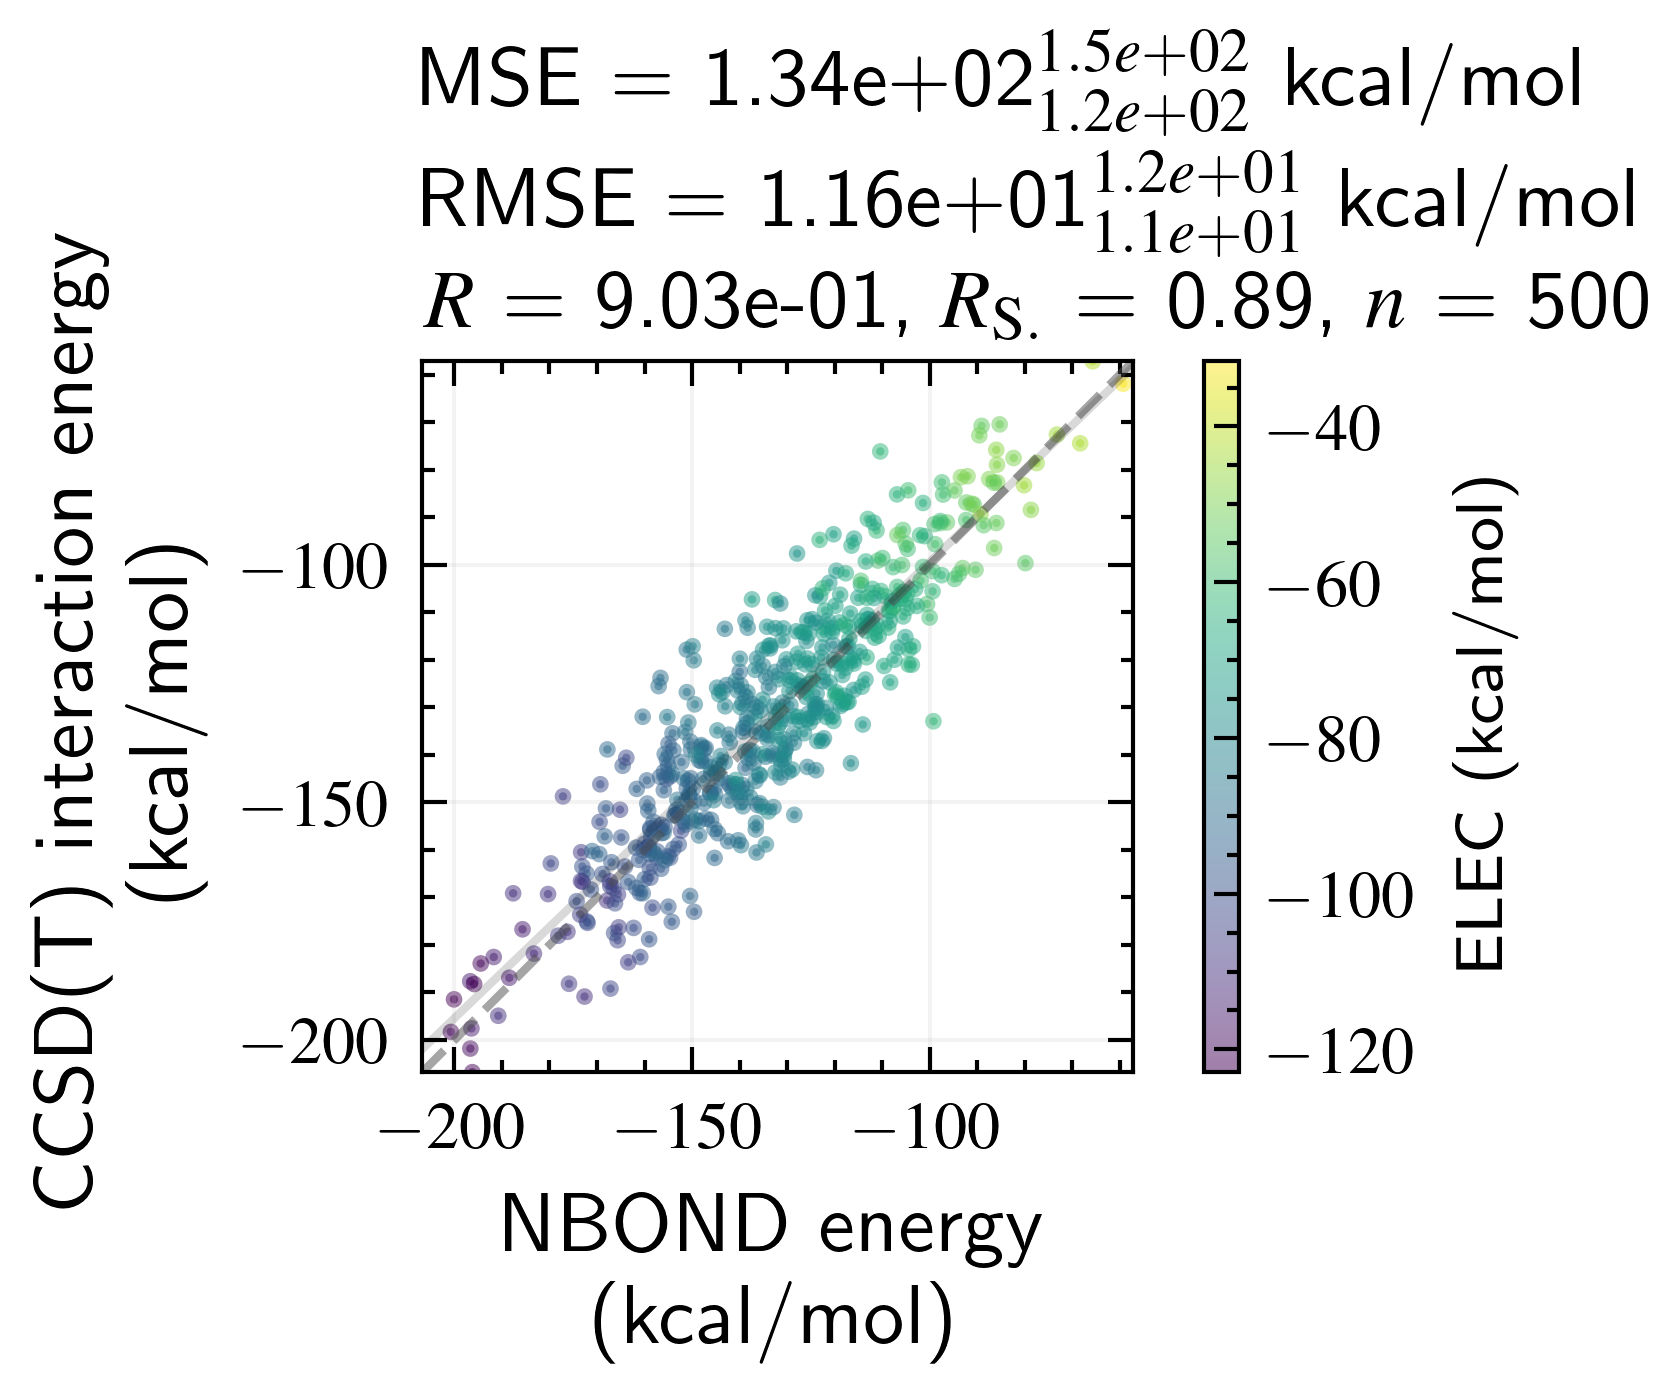

In [11]:
# _c.eval_jax_chgpen(resx ) 
_c.data["fit_ECOL"] = _c.eval_jax_chgpen(resx ) + _c.data.ELEC

plot_energy_MSE(_c.data, "ECOL", "fit_ECOL",  elec = "ELEC")



4.56111580439e-312


(<Axes: xlabel='NBOND energy\n(kcal/mol)', ylabel='CCSD(T) interaction energy\n(kcal/mol)'>,
 {'MSE': 2910.60610280599,
  'RMSE': 53.95003339022127,
  'R': 0.9711142986643587,
  'RS': 0.9681705926823706,
  'n': 500,
  'slope': 0.6036835299777032,
  'intercept': -0.12110096819104399})

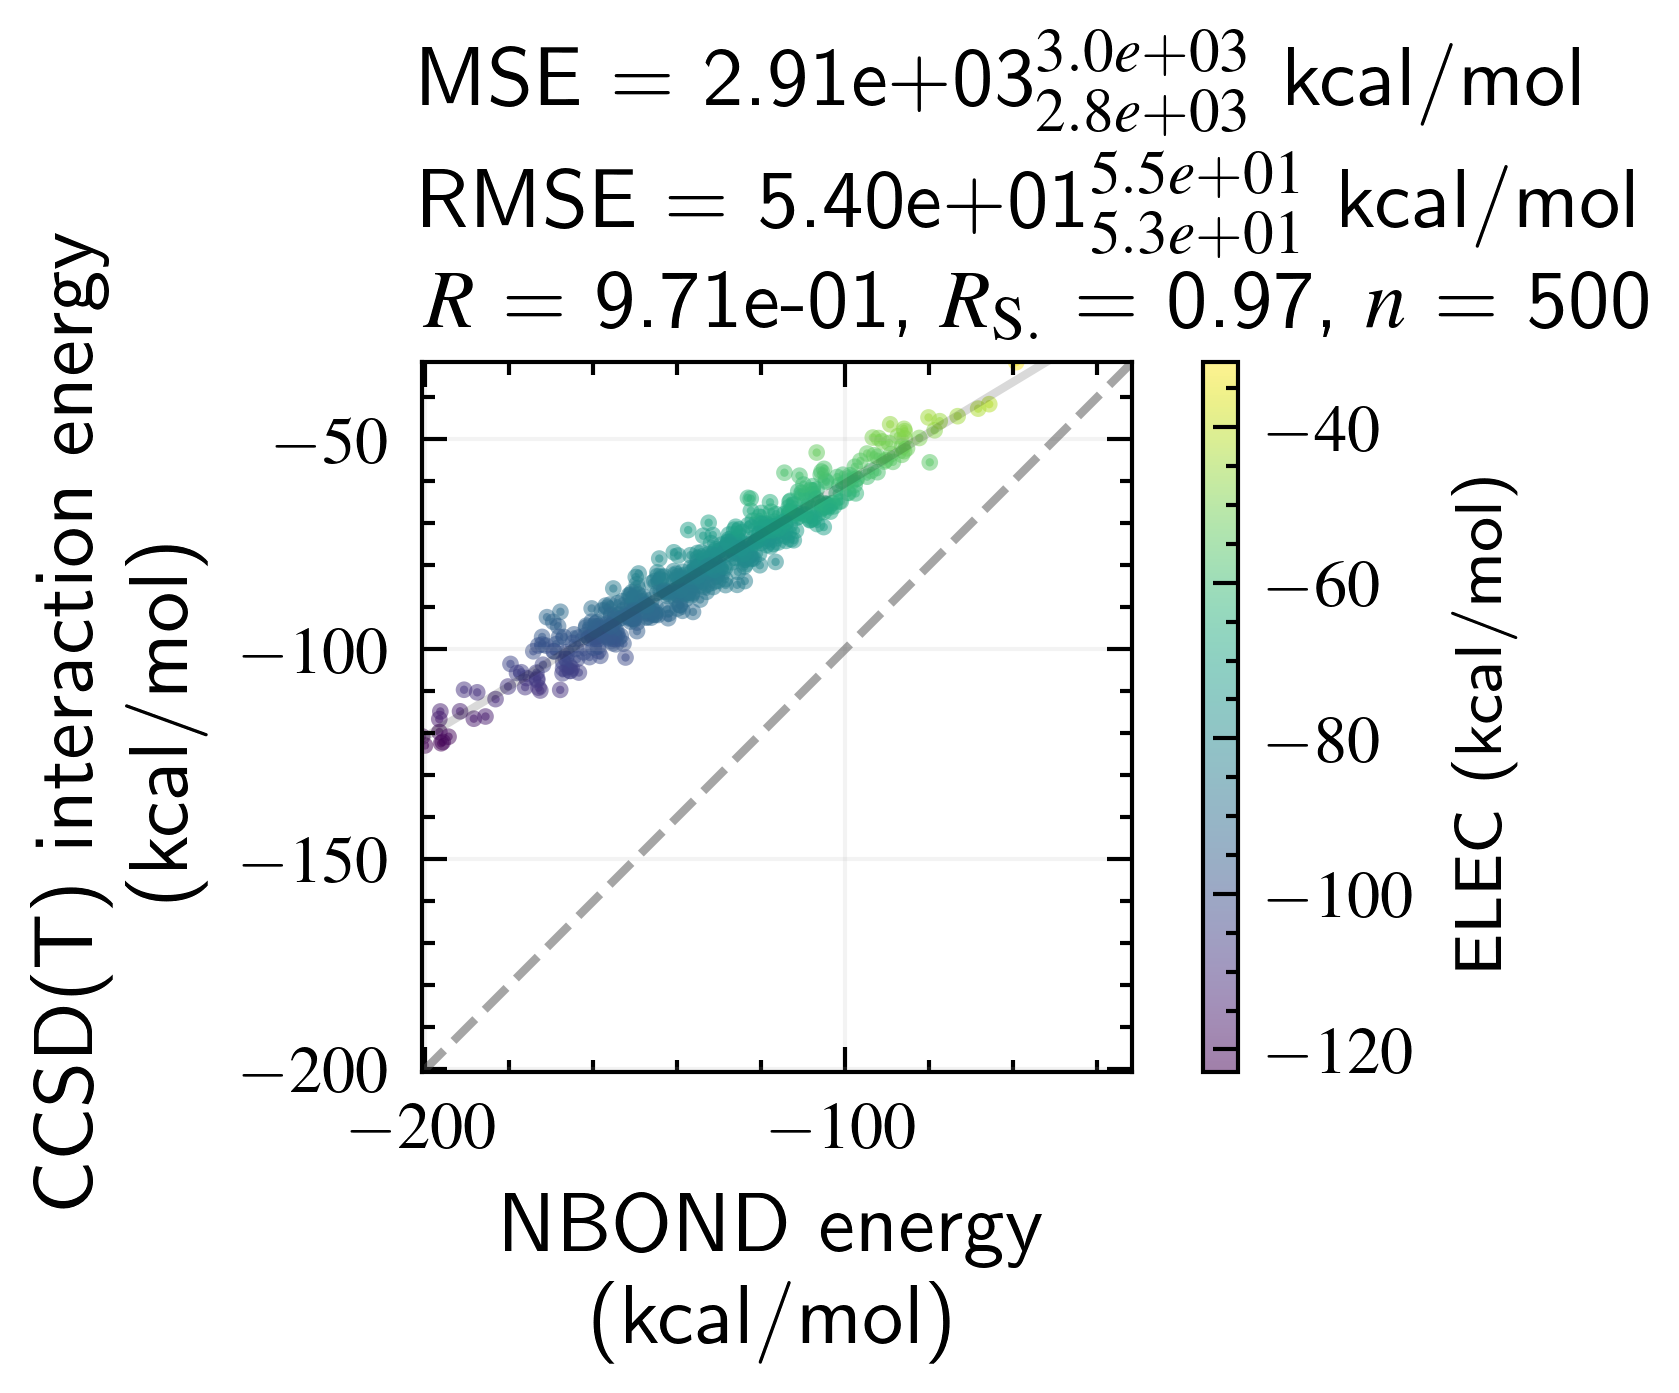

In [12]:
plot_energy_MSE(_c.data, "ECOL", "ELEC",  elec = "ELEC")

In [35]:
_c.data["fit_ECOL"].mean()

-131.89888

In [13]:
pickle_output(_c, "ff/fit_ECOL_mdcm_intE")

#  LJ fit


In [14]:
# _c = next(read_from_pickle(f"ff/{ffpkl}"))
LJFF = next(read_from_pickle(f"ff/fit_ECOL_mdcm_intE.pkl"))

In [50]:
LJFF.elec = "fit_ECOL"
LJFF.intE = "intE"
LJFF.set_intE()
LJFF.set_targets()
print(LJFF.targets.mean())
LJFF

72.77082


FF: LJ water_cluster fit_ECOL harmonic intE (jax_coloumb: True)

In [51]:
fit_repeat(LJFF, 
           10, 
           f"{ffpkl}_LJ",
           bounds = LJ_bound,
           loss="jax",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:175: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


In [32]:
pd.DataFrame(LJFF.opt_results).sort_values("fun")

,fun,nit,nfev,status,success,message,x,final_simplex
10,16.345823,373,660,0,True,Optimization terminated successfully.,"[0.5278901381978127, 1.0483191146777542, 2.5, ...","([[0.5278901381978127, 1.0483191146777542, 2.5..."
5,16.345823,268,494,0,True,Optimization terminated successfully.,"[0.5276192227974474, 1.0484875619735297, 2.5, ...","([[0.5276192227974474, 1.0484875619735297, 2.5..."
9,16.345829,244,427,0,True,Optimization terminated successfully.,"[0.5276153957027089, 1.0484913128948625, 2.499...","([[0.5276153957027089, 1.0484913128948625, 2.4..."
12,16.345833,314,570,0,True,Optimization terminated successfully.,"[0.5276153862907726, 1.0484957057234165, 2.5, ...","([[0.5276153862907726, 1.0484957057234165, 2.5..."
1,16.345835,283,496,0,True,Optimization terminated successfully.,"[0.5277545837802455, 1.0484062226669184, 2.5, ...","([[0.5277545837802455, 1.0484062226669184, 2.5..."
8,16.345835,327,579,0,True,Optimization terminated successfully.,"[0.5274524939005367, 1.0485907661586822, 2.499...","([[0.5274524939005367, 1.0485907661586822, 2.4..."
19,16.345839,387,690,0,True,Optimization terminated successfully.,"[0.5281889643790445, 1.0481347998167436, 2.5, ...","([[0.5281889643790445, 1.0481347998167436, 2.5..."
18,16.345856,226,418,0,True,Optimization terminated successfully.,"[0.527532977100127, 1.0485288060419642, 2.5, 2...","([[0.527532977100127, 1.0485288060419642, 2.5,..."
11,16.345888,414,716,0,True,Optimization terminated successfully.,"[0.5284120862166862, 1.0479712330962223, 2.499...","([[0.5284120862166862, 1.0479712330962223, 2.4..."
7,16.345913,481,822,0,True,Optimization terminated successfully.,"[0.5266399056408049, 1.0491027256685683, 2.499...","([[0.5266399056408049, 1.0491027256685683, 2.4..."


In [38]:
bestres = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").x)[0]
bestres

array([0.52789014, 1.04831911, 2.5       , 2.5       ])

In [45]:
abs(LJFF.eval_jax(bestres)).mean()

Array(53.09783, dtype=float32)

In [46]:
abs(LJFF.targets).mean()

Array(52.916824, dtype=float32)

In [33]:
best = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").fun)[0]
np.sqrt(best)

4.042996820177313

#  DE fit


In [49]:
# _c = next(read_from_pickle(f"ff/{ffpkl}"))
DEFF = next(read_from_pickle(f"ff/fit_ECOL_mdcm_intE.pkl"))
DEFF.elec = "fit_ECOL"
DEFF.data.intE.abs().mean()

59.12803914354881

In [29]:
fit_repeat(DEFF, 
           10, 
           "test",
           bounds = DE_bound,
           loss="jax_de",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:175: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


In [30]:
pd.DataFrame(DEFF.opt_results).sort_values("fun")

,fun,nit,nfev,status,success,message,x,final_simplex
7,11.775151,964,1559,0,True,Optimization terminated successfully.,"[0.3411363344649736, 1.2834539826299567, 2.5, ...","([[0.3411363344649736, 1.2834539826299567, 2.5..."
11,11.775182,596,1013,0,True,Optimization terminated successfully.,"[0.3410279489227199, 1.2835442577247882, 2.499...","([[0.3410279489227199, 1.2835442577247882, 2.4..."
6,11.775245,1476,2327,0,True,Optimization terminated successfully.,"[0.34114571204260147, 1.283410496813493, 2.499...","([[0.34114571204260147, 1.283410496813493, 2.4..."
20,11.775511,1283,2046,0,True,Optimization terminated successfully.,"[0.3406634610028251, 1.2834286543030644, 2.499...","([[0.3406634610028251, 1.2834286543030644, 2.4..."
9,11.776557,581,946,0,True,Optimization terminated successfully.,"[0.3407296851411241, 1.2837287936298885, 2.499...","([[0.3407296851411241, 1.2837287936298885, 2.4..."
17,11.777202,943,1549,0,True,Optimization terminated successfully.,"[0.34070603589209786, 1.2838674274856148, 2.49...","([[0.34070603589209786, 1.2838674274856148, 2...."
1,11.792897,1024,1623,0,True,Optimization terminated successfully.,"[0.3391777333651863, 1.2858844652607933, 2.499...","([[0.3391777333651863, 1.2858844652607933, 2.4..."
16,11.793501,729,1197,0,True,Optimization terminated successfully.,"[0.3392183785149385, 1.2858566511837575, 2.499...","([[0.3392183785149385, 1.2858566511837575, 2.4..."
8,11.793520,1672,2621,0,True,Optimization terminated successfully.,"[0.33895459035051223, 1.2859510668931469, 2.49...","([[0.33895459035051223, 1.2859510668931469, 2...."
18,14.313481,740,1191,0,True,Optimization terminated successfully.,"[0.4379737380241687, 1.1385457267294805, 2.5, ...","([[0.4379737380241687, 1.1385457267294805, 2.5..."


In [27]:
# np.sqrt(10.7)

In [28]:
best = list(pd.DataFrame(\
                  DEFF.opt_results)\
     .sort_values("fun").fun)[0]
np.sqrt(best)

3.4314940263311815

In [ ]:
DEFF.